In [5]:
# import necessary libraries
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import bleach

# datasets library 
# contains 'hyperpartisan_news_detection' dataset
import datasets
from datasets import list_datasets, load_dataset, list_metrics, load_metric
datasets_list = list_datasets()

# OneVsRest LightGBM with Focal Loss
from OneVsRestLightGBMWithCustomizedLoss import *
from FocalLoss import FocalLoss

# text resources
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('punkt')

In [6]:
# importing the dataset
dataset  = datasets.load_dataset('hyperpartisan_news_detection', 'bypublisher')
dataset

Reusing dataset hyperpartisan_news_detection (/Users/shubhang/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)


DatasetDict({
    train: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
    validation: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
})

In [7]:
# dataset details
print("Size of the training set: ", dataset['train'].shape)

# dataset examples
print("Example text: \n", dataset['train'][69]['text'])
print("Length: ", len(dataset['train'][69]['text'].split(" ")))
print("Hyperpartisan: ",  dataset['train'][69]['hyperpartisan'])
print("Bias: ",  dataset['train'][69]['bias'])

Size of the training set:  (600000, 6)
Example text: 
 <p>May 1966. &amp;#160;Mitt Romney is just finishing his first&#8212;and only&#8212;year at Stanford.&amp;#160; I&#8217;m a 32-year-old ex-Strategic Air Command navigator and intelligence officer, now an associate professor in Stanford&#8217;s English Department and something of an anti-Vietnam War activist.</p> 

<p>About a quarter of a million young American men are already being abducted each year to fight the rapidly-escalating Vietnam War. &amp;#160;Many college students, however, are protected by their 2S student deferments, which blatantly discriminate against all those millions of other young men unable to afford college.&amp;#160; As if this privileging of the relatively privileged were not sufficient, an outcry about &#8220;inequity&#8221; arises from administrations of some elite universities.&amp;#160; Since the 2S deferment is contingent on relatively high class rank (meaning, of course, academic class rank), they argu

In [8]:
# text preprocessing function
def text_preprocess(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
    text = bleach.clean(text,strip=True) # bleach clean
    text = text.replace('<p>', '')
    text = text.replace('</p>', '')
    text = text.replace('\n', '')
    text = text.replace('&amp;#160;', '')
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = text.replace('\n', ' ').lower() # lowercase text
    text = REPLACE_IP_ADDRESS.sub('', text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('',text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([w for w in text.split() if not w in STOPWORDS]) # delete stopwords from text
    return text

# generating tf-idf features from text
def tfidf_features(X_train, X_test):
    """
        X_train, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_,tfidf_vectorizer

In [9]:
# picking elements from training data
train_size = 50000
train_indices = np.random.randint(0, len(dataset['train']), train_size)

train_dataset = dataset['train'].select(train_indices)

In [10]:
# training set details
train_dataset

Dataset({
    features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
    num_rows: 50000
})

#### This particular dataset contains two columns of interest.
#### ---------------------------------------------------------------------------------------
#### 1. Hyperpartisan: Indicates whether a news article is biased or not
#### 2. Bias: Indicates the bias level of the article as follows-

#### If bias value = 0, bias: right
#### If bias value = 1, bias: right-center
#### If bias value = 2, bias: least
#### If bias value = 3, bias: left-center
#### If bias value = 4, bias: left
#### ---------------------------------------------------------------------------------------
#### Reference- https://huggingface.co/datasets/hyperpartisan_news_detection
#### ---------------------------------------------------------------------------------------
#### Here, we will focus on predicting the bias level of an incoming article.

In [11]:
# retaining necessary columns
df = pd.DataFrame(train_dataset)
df = df[['title', 'text','hyperpartisan', 'bias']]

df.head()

,title,text,hyperpartisan,bias
0,How Hurricane Harvey will ripple through the U...,<p>Hurricane Harvey will distort measures of t...,True,0
1,Hurricane Earl Weakens to Tropical Storm After...,<p>A storm system that had been a hurricane wh...,False,3
2,Manhunt On for Revenge-Seeking Ex-LAPD Officer...,<p>Thousands of police officers in Southern Ca...,True,4
3,US judge seeks internal communications in Turk...,<p>NEW YORK (AP) &#8212; A federal judge wants...,False,2
4,How To Stick With Emerging Markets If The Doll...,"<p>No, it is not a coincidence. The U.S. Dolla...",True,0


In [12]:
# text preprocessing
df['clean_text'] = df['text'].apply(lambda x:text_preprocess(x))
df.head()

,title,text,hyperpartisan,bias,clean_text
0,How Hurricane Harvey will ripple through the U...,<p>Hurricane Harvey will distort measures of t...,True,0,hurricane harvey distort measures us economy w...
1,Hurricane Earl Weakens to Tropical Storm After...,<p>A storm system that had been a hurricane wh...,False,3,storm system hurricane roared ashore belize ea...
2,Manhunt On for Revenge-Seeking Ex-LAPD Officer...,<p>Thousands of police officers in Southern Ca...,True,4,thousands police officers southern california ...
3,US judge seeks internal communications in Turk...,<p>NEW YORK (AP) &#8212; A federal judge wants...,False,2,new york ap #8212 federal judge wants lawyers ...
4,How To Stick With Emerging Markets If The Doll...,"<p>No, it is not a coincidence. The U.S. Dolla...",True,0,coincidence us dollar index 46 percent yeartod...


In [13]:
# displaying the X and y values
X = df.iloc()[:,-1].values
y = df.iloc()[:,-2]
display(X[:5],y[:5])

array(['hurricane harvey distort measures us economy weeks months ahead making difficult economists policy makers gauge trajectory sensitive time federal reserve everything jobless claims already surged report thursday gross domestic product inflation knocked course brief spikes across wide range reports economists say impact hurricane irma could devastate cities across southeast continue reading hard discern whether bad reports result storm damage whether good reports owe effects rebuilding fed already struggling conflicting signals decides path rate rises must look even greater volatility inflation reports could well 2018 effects storms fully washed economic data forecasters wall street journals survey economists expect storm reduce pace job gains 27 000 jobs month third quarter average followed little change fourth quarter boost 13 000 first quarter 2018 many people find work rebuilding fed policy makers watch job growth closely signs whether labor market tightening economists also 

0    0
1    3
2    4
3    2
4    0
Name: bias, dtype: int64

In [14]:
# mapping dictionary for bias values
mapping_dict = {0: "right", 1: "right-center", 2: "neutral", 3: "left-center", 4:"left"}
mapping_dict

{0: 'right', 1: 'right-center', 2: 'neutral', 3: 'left-center', 4: 'left'}

In [16]:
# train-test split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [17]:
# generating tf-idf features
X_train_tfidf, X_test_tfidf, tfidf_vocab, vectorizer = tfidf_features(Xtrain, Xtest)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
X_train_tfidf

<40000x432548 sparse matrix of type '<class 'numpy.float64'>'
	with 14750194 stored elements in Compressed Sparse Row format>

### LightGBM Multi-class Classification WITHOUT Focal Loss

In [18]:
# converting the dataset to proper LGB format
d_train = lgb.Dataset(X_train_tfidf, label=Ytrain)

In [20]:
# setting up the parameters
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' # GradientBoostingDecisionTree
params['objective']='multiclass' # Multi-class target feature
params['metric']='multi_logloss' # metric for multi-class
params['max_depth']=15
params['num_class']=5 # no.of unique values in the target class not inclusive of the end value

In [21]:
%%time
# training the model for 100 epochs
clf=lgb.train(params,d_train,100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 12.614984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2695088
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 80259
[LightGBM] [Info] Start training from score -1.384097
[LightGBM] [Info] Start training from score -2.631089
[LightGBM] [Info] Start training from score -1.178143
[LightGBM] [Info] Start training from score -2.145795
[LightGBM] [Info] Start training from score -1.375849
CPU times: user 35min 37s, sys: 14min 7s, total: 49min 45s
Wall time: 9min 16s


In [22]:
# prediction on the test dataset
y_pred_1=clf.predict(X_test_tfidf)
y_pred_1

array([[0.97039466, 0.00933982, 0.00521152, 0.00569622, 0.00935779],
       [0.22016345, 0.2378346 , 0.14958948, 0.06105482, 0.33135765],
       [0.98945738, 0.00108094, 0.00416553, 0.00180167, 0.00349448],
       ...,
       [0.16756673, 0.01453756, 0.05340666, 0.65859444, 0.10589461],
       [0.989022  , 0.00132361, 0.00436816, 0.00186348, 0.00342274],
       [0.01344751, 0.00675224, 0.9545743 , 0.00521855, 0.02000741]])

In [23]:
# argmax() method 
y_pred_1 = [np.argmax(line) for line in y_pred_1]
#y_pred_1

In [24]:
# using precision score for error metrics
precision_score(y_pred_1,Ytest,average=None).mean()

0.8610286895696987

In [25]:
import itertools
import matplotlib.pyplot as plt

# plotting confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
classes=[]
# unique labels (1...4)
labels = np.unique(y)

# respective label names
labels_names = list(mapping_dict.values())
for v in labels_names:
    classes.append(v)
print(classes, labels)

['right', 'right-center', 'neutral', 'left-center', 'left'] [0 1 2 3 4]


Prediction accuracy 0.8886  recall  0.8610286895696987
Normalized confusion matrix
[[0.85514765 0.00438947 0.00239425 0.01276935 0.12529928]
 [0.02638889 0.825      0.00277778 0.025      0.12083333]
 [0.00097434 0.         0.9425138  0.00714518 0.04936668]
 [0.01710864 0.00171086 0.01112062 0.73909324 0.23096664]
 [0.02573238 0.00316706 0.00831354 0.01939826 0.94338876]]


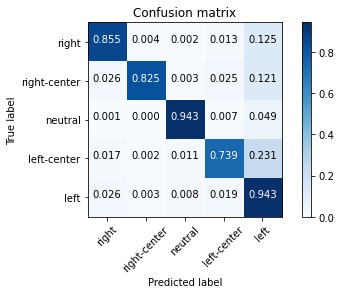

In [27]:
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix,roc_auc_score

pred_accuracy_score = accuracy_score(Ytest, y_pred_1)
pred_recall_score = recall_score(Ytest, y_pred_1, average='macro')
print('Prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(Ytest, y_pred_1, labels=labels)
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,  title='Confusion matrix')

#####  Without Focal Loss, the results seem good enough.
##### LightGBM stands tall on its own merits.

### LightGBM Multi-class Classification WITH Focal Loss

array([0, 4, 0, ..., 3, 0, 2])

prediction accuracy 0.9105  recall  0.8870261624339731  precision  0.9166075024338429
Normalized confusion matrix
[[0.8886672  0.0027933  0.00319234 0.01636073 0.08898643]
 [0.03611111 0.83333333 0.00833333 0.0375     0.08472222]
 [0.00129912 0.00097434 0.95582981 0.00746996 0.03442676]
 [0.01967494 0.00171086 0.01368691 0.81351583 0.15141146]
 [0.02573238 0.00197941 0.00831354 0.02019002 0.94378464]]
CPU times: user 8.2 s, sys: 7.24 s, total: 15.4 s
Wall time: 10min 1s


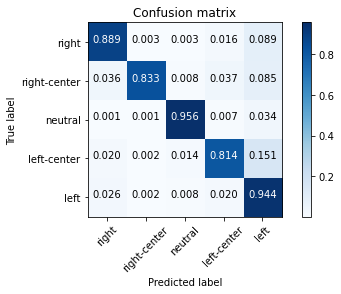

In [30]:
%%time
from OneVsRestLightGBMWithCustomizedLoss import *
from FocalLoss import FocalLoss

# Instantiate Focal loss
loss = FocalLoss(alpha=0.75, gamma=2.0)

clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)

# Using early stopping
fit_params = {'eval_set': [(X_test_tfidf, Ytest)]}
clf.fit(X_train_tfidf, Ytrain, **fit_params)

y_test_pred = clf.predict(X_test_tfidf)
# y_test_pred_prob = clf.predict_proba(X_test_tfidf)
display(y_test_pred)

pred_accuracy_score = accuracy_score(Ytest, y_test_pred)
pred_precision_score = precision_score(Ytest, y_test_pred,average='macro')
pred_recall_score = recall_score(Ytest, y_test_pred, average='macro')
print('prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score, ' precision ', pred_precision_score)

cnf_matrix = confusion_matrix(Ytest, y_test_pred, labels=labels)
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,  title='Confusion matrix')

##### With Focal Loss, performance shoots up. This model outperforms the one without customized loss.

In [36]:
display(classes)
with open('labels.npy', 'wb') as f:
    np.save(f, classes)

['right', 'right-center', 'neutral', 'left-center', 'left']

In [37]:
import pickle
vec_file = 'vectorizer_LGBM_BiasDetection.pickle'
pickle.dump(vectorizer, open(vec_file, 'wb'))

# Saving the model with the Focal Loss
mod_file = 'BiasDetection_LGBM.model'
pickle.dump(clf, open(mod_file, 'wb'))

### Loading the model from disk and predicting

In [2]:
import pickle
import re
import bleach
from nltk.corpus import stopwords

# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer_LGBM_BiasDetection.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('BiasDetection_LGBM.model', 'rb'))

def text_preprocess(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
    text = bleach.clean(text,strip=True) # bleach clean
    text = text.replace('<p>', '')
    text = text.replace('</p>', '')
    text = text.replace('\n', '')
    text = text.replace('&amp;#160;', '')
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = text.replace('\n', ' ').lower()# lowercase text
    text = REPLACE_IP_ADDRESS.sub('', text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([w for w in text.split() if not w in STOPWORDS])# delete stopwords from text
    return text

def get_bias(utt):
    # mapping dictionary
    mapping_dict = {0: "right", 1: "right-center", 2: "neutral", 3: "left-center", 4:"left"}
    
    # make a prediction
    prediction = loaded_model.predict(loaded_vectorizer.transform([utt]))
    probability = loaded_model.predict_proba(loaded_vectorizer.transform([utt]))[0]
    max_prob = max(probability)
    result = mapping_dict.get(prediction[0])
    print(' Class: ', result,'\n', 'Class score: ' ,max_prob, '\n','All probabilities: ', probability)

In [3]:
# testing
# Source - Fox News

text = '''
Two women plead guilty to hate crime for attacking Trump supporters

Delaware women accused of ripping MAGA hat from Trump supporter at DNC

Two women who stole a "Make America Great Again" hat from a President Trump supporter at the Democratic National Convention have pleaded guilty to hate crimes in connection to the viral confrontation.

Olivia Winslow and Camryn Amy were caught on video on Aug. 20 destroying Trump signs and snatching a red MAGA cap outside the DNC in Wilmington, Delaware, as Joe Biden gave his acceptance speech. 

The women, both of Wilmington, have pleaded guilty to charges of theft, child endangerment and hate crimes in the incident outside a restaurant at the Wilmington Riverfront, the Delaware News Journal reported Wednesday.

Winslow and Amy will be sentenced in September. Prosecutors will not seek prison time and their attorneys said they agree that probation is the "appropriate sentence" in the case while declining further comment, the News Journal reported.

Charges of assault, attempted assault and conspiracy were dropped as part of a plea deal struck Monday, according to the report.

The footage, which was viewed more than 5 million times, was posted on Twitter by Students for Trump. Cops in Wilmington reportedly tracked down Winslow and Amy shortly after watching the clip.

"Are you destroying my property?" an unidentified woman asks in the clip as Winslow and Amy tear up her Trump signs. The pair then turn their attention to a MAGA hat on the ground, the footage shows.

"Get it, Liv, get it," Amy tells Winslow.

The woman’s son protests, saying "That’s somebody else’s hat!" as the women walk away, setting off a confrontation that included with a possible relative who is punched when he tried to get the cap back.

Winslow and Amy double back to confront the boy’s mom, with Amy hitting her, the two-minute clip shows.
'''

text = text_preprocess(text)
get_bias(text)

 Class:  right 
 Class score:  0.37257929489535824 
 All probabilities:  [0.37257929 0.13021111 0.08578945 0.19852425 0.2128959 ]
